# Register Number: 8569202378

# Name: Ashvant Ram Selvam

## Question 1

(a) Download the banknote authentication Data Set from: https://archive.ics.
uci.edu/ml/datasets/banknote+authentication. Choose 472 data points randomly
as the test set. This is a binary classification problem

In [5]:
import pandas as pd
fileData = pd.read_csv("data_banknote_authentication.csv",header=None)
column_list=["variance","skewness","curtosis","entropy","class"]
fileData.columns=column_list
print(fileData)

      variance  skewness   curtosis   entropy  class
0     3.621600   8.66610  -2.807300 -0.446990      0
1     4.545900   8.16740  -2.458600 -1.462100      0
2     3.866000  -2.63830   1.924200  0.106450      0
3     3.456600   9.52280  -4.011200 -3.594400      0
4     0.329240  -4.45520   4.571800 -0.988800      0
5     4.368400   9.67180  -3.960600 -3.162500      0
6     3.591200   3.01290   0.728880  0.564210      0
7     2.092200  -6.81000   8.463600 -0.602160      0
8     3.203200   5.75880  -0.753450 -0.612510      0
9     1.535600   9.17720  -2.271800 -0.735350      0
10    1.224700   8.77790  -2.213500 -0.806470      0
11    3.989900  -2.70660   2.394600  0.862910      0
12    1.899300   7.66250   0.153940 -3.110800      0
13   -1.576800  10.84300   2.546200 -2.936200      0
14    3.404000   8.72610  -2.991500 -0.572420      0
15    4.676500  -3.38950   3.489600  1.477100      0
16    2.671900   3.06460   0.371580  0.586190      0
17    0.803550   2.84730   4.343900  0.601700 

(b) Repeat each of the following two procedures 50 times. You will have 50 errors for
90 SVMs per each procedure.
i. Train a SVM with a pool of 10 randomly selected data points from the training
set using linear kernel and L1 penalty. Select the penalty parameter using
10-fold cross validation.1 Repeat this process by adding 10 other randomly
selected data points to the pool, until you use all the 900 points. Do NOT
replace the samples back into the training set at each step. Calculate the
test error for each SVM. You will have 90 SVMs that were trained using 10,
20, 30, ... , 900 data points and their 90 test errors. You have implemented
passive learning.
ii. Train a SVM with a pool of 10 randomly selected data points from the training
set using linear kernel and L1 penalty. Select the parameters of the SVM with
10-fold cross validation. Choose the 10 closest data points in the training set
to the margin of the SVM2 and add them to the pool. Do not replace the
samples back into the training set. Train a new SVM using the pool.Repeat
this process until all training data is used. You will have 90 SVMs that were
trained using 10, 20, 30,..., 900 data points and their 90 test errors. You have
implemented active learning

In [13]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import numpy as np

In [21]:
def shuffle_train(train,test):
    train=train.sample(frac=1)
    if np.sum(train["class"][:10])>2 and np.sum(train["class"][:10])<8:
        return train, test
    else:
        return shuffle_train(train,test)

In [15]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

In [16]:
def cross_val(svc, trainCrossData, trainCrossLabel, cv=10):
    kf = KFold(n_splits=cv)
    cv_score = 0
    for train_index, test_index in kf.split(trainCrossData, trainCrossLabel):
        X_train, X_val = trainCrossData.iloc[train_index], trainCrossData.iloc[test_index]
        y_train, y_val = trainCrossLabel.iloc[train_index], trainCrossLabel.iloc[test_index]
        svc.fit(X_train, y_train)
        cv_score += svc.score(X_val, y_val)
    return cv_score/cv

In [32]:
def tenNearest(svc,trainData,trainLabel):
    dist = []
    dist = svc.decision_function(trainData)
    dist = np.absolute(dist)
    indexes_next = np.argsort(dist)[:10]
    indexes_remainder = set(range(trainData.shape[0])) - set(indexes_next)
    trainData_remainder = trainDataRest.take(list(indexes_remainder))
    trainData_nearest = trainDataRest.take(list(indexes_next))
    trainLabel_remainder = trainLabel.take(list(indexes_remainder))
    trainLabel_nearest = trainLabel.take(list(indexes_next))
    return trainData_nearest, trainData_remainder, trainLabel_nearest,trainLabel_remainder

In [34]:
passive_array = []
active_array = []
train, test = train_test_split(fileData, test_size=472)
for i in range(1,51):
    #passive
    train,test = shuffle_train(train, test)
    trainLabel = train["class"]
    trainData = train.drop("class",axis=1)
    testLabel = test["class"]
    testData = test.drop("class",axis=1)
    print("Iteration",i,"/50")
    test_error_passive_array = []
    for i in range(10,901,10):
        cv_error_list = []
        accuracy = 0
        cvalues = (10**np.array(range(1,6)))/1000
        for c in cvalues:
            svc = LinearSVC(penalty='l1', C=c, dual=False)
            accuracy = cross_val(svc, trainData.iloc[:i],trainLabel.iloc[:i], cv=10)
            cv_error_list.append(1-accuracy)
        bestCvalueIndex = cv_error_list.index(min(cv_error_list))
        bestCvalue = cvalues[bestCvalueIndex]
        print("Cvalue-best:",bestCvalue)
        svc = LinearSVC(penalty='l1', C=bestCvalue, dual=False)
        svc.fit(trainData.iloc[:i], trainLabel.iloc[:i])
        test_accuracy = accuracy_score(testLabel, svc.predict(testData))
        print("Number of Samples" + str(i) + ", Error: " + str(1-test_accuracy))
        test_error_passive_array.append(1-test_accuracy)
    passive_array.append(test_error_passive_array)
    
    
    #active
    test_error_active_array = []
    trainDataPool,trainLabelPool = trainData.iloc[:10],trainLabel.iloc[:10]
    trainDataRest,trainLabelRest = trainData.iloc[10:],trainLabel.iloc[10:]
    cv_error_list = []
    accuracy = 0
    cvalues = (10**np.array(range(1,6)))/1000
    for c in cvalues:
        svc = LinearSVC(penalty='l1', C=c, dual=False)
        accuracy = cross_val(svc,trainDataPool ,trainLabelPool, cv=10)
        cv_error_list.append(1-accuracy)
    bestCvalueIndex = cv_error_list.index(min(cv_error_list))
    bestCvalue = cvalues[bestCvalueIndex]
    print("Cvalue-best:",bestCvalue)
    svc = LinearSVC(penalty='l1', C=bestCvalue, dual=False)
    svc.fit(trainDataPool,trainLabelPool)
    test_accuracy = accuracy_score(testLabel, svc.predict(testData))
    print("Number of Samples" + str(10) + ", Error: " + str(1-test_accuracy))
    test_error_active_array.append(1-test_accuracy)
    
    for i in range(20,901,10):
        trainDataNearest,trainDataRest,trainLabelNearest,trainLabelRest = tenNearest(svc,trainDataRest,trainLabelRest)
        trainDataPool, trainLabelPool = pd.concat([trainDataPool, trainDataNearest]), pd.concat([trainLabelPool, trainLabelNearest])
        cv_error_list = []
        accuracy = 0
        cvalues = (10**np.array(range(1,6)))/1000
        for c in cvalues:
            svc = LinearSVC(penalty='l1', C=c, dual=False)
            accuracy = cross_val(svc,trainDataPool ,trainLabelPool, cv=10)
            cv_error_list.append(1-accuracy)
        bestCvalueIndex = cv_error_list.index(min(cv_error_list))
        bestCvalue = cvalues[bestCvalueIndex]
        print("Cvalue-best:",bestCvalue)
        svc = LinearSVC(penalty='l1', C=bestCvalue, dual=False)
        svc.fit(trainDataPool,trainLabelPool)
        test_accuracy = accuracy_score(testLabel, svc.predict(testData))
        print("Number of Samples" + str(i) + ", Error: " + str(1-test_accuracy))
        test_error_active_array.append(1-test_accuracy)
    active_array.append(test_error_active_array)

Iteration 1 /50
Cvalue-best: 1.0
Number of Samples10, Error: 0.0974576271186
Cvalue-best: 1.0
Number of Samples20, Error: 0.118644067797
Cvalue-best: 0.1
Number of Samples30, Error: 0.0826271186441
Cvalue-best: 0.1
Number of Samples40, Error: 0.0720338983051
Cvalue-best: 10.0
Number of Samples50, Error: 0.0296610169492
Cvalue-best: 10.0
Number of Samples60, Error: 0.021186440678
Cvalue-best: 100.0
Number of Samples70, Error: 0.0127118644068
Cvalue-best: 100.0
Number of Samples80, Error: 0.0127118644068
Cvalue-best: 100.0
Number of Samples90, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples100, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples110, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples120, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples130, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples140, Error: 0.00847457627119
Cvalue-best: 10.0
Number of Samples150, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples160, Error: 0.01059322

Cvalue-best: 0.1
Number of Samples420, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples430, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples440, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples450, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples460, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples470, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples480, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples490, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples500, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples510, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples520, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples530, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples540, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples550, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples560, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples570, Error: 0.00847457627

Cvalue-best: 0.1
Number of Samples840, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples850, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples860, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples870, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples880, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples890, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples900, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples10, Error: 0.114406779661
Cvalue-best: 100.0
Number of Samples20, Error: 0.0635593220339
Cvalue-best: 10.0
Number of Samples30, Error: 0.0656779661017
Cvalue-best: 1.0
Number of Samples40, Error: 0.021186440678
Cvalue-best: 1.0
Number of Samples50, Error: 0.00847457627119
Cvalue-best: 10.0
Number of Samples60, Error: 0.00847457627119
Cvalue-best: 10.0
Number of Samples70, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples80, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples90, Error: 0.010593220339
Cvalu

Cvalue-best: 0.1
Number of Samples350, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples360, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples370, Error: 0.0148305084746
Cvalue-best: 1.0
Number of Samples380, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples390, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples400, Error: 0.010593220339
Cvalue-best: 10.0
Number of Samples410, Error: 0.00635593220339
Cvalue-best: 1.0
Number of Samples420, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples430, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples440, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples450, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples460, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples470, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples480, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples490, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples500, Error: 0.010593220339
Cvalue-best:

Cvalue-best: 0.1
Number of Samples770, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples780, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples790, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples800, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples810, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples820, Error: 0.00847457627119
Cvalue-best: 10.0
Number of Samples830, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples840, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples850, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples860, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples870, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples880, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples890, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples900, Error: 0.00847457627119
Iteration 4 /50
Cvalue-best: 1.0
Number of Samples10, Error: 0.129237288136
Cvalue-best: 0.1
Number of Samples20, Error

Cvalue-best: 0.1
Number of Samples290, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples300, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples310, Error: 0.00847457627119
Cvalue-best: 100.0
Number of Samples320, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples330, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples340, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples350, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples360, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples370, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples380, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples390, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples400, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples410, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples420, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples430, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples440, Error: 0.008474

Cvalue-best: 0.1
Number of Samples700, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples710, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples720, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples730, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples740, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples750, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples760, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples770, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples780, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples790, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples800, Error: 0.00635593220339
Cvalue-best: 0.1
Number of Samples810, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples820, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples830, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples840, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples850, Error: 0.0084745

Cvalue-best: 0.1
Number of Samples220, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples230, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples240, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples250, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples260, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples270, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples280, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples290, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples300, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples310, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples320, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples330, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples340, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples350, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples360, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples370, Error: 0.00847457627119


Cvalue-best: 1.0
Number of Samples630, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples640, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples650, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples660, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples670, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples680, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples690, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples700, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples710, Error: 0.00847457627119
Cvalue-best: 10.0
Number of Samples720, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples730, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples740, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples750, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples760, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples770, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples780, Error: 0.0127118644068


Cvalue-best: 1.0
Number of Samples150, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples160, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples170, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples180, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples190, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples200, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples210, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples220, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples230, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples240, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples250, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples260, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples270, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples280, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples290, Error: 0.0127118644068
Cvalue-best: 100.0
Number of Samples300, Error: 0.0127118644068
Cval

Cvalue-best: 1.0
Number of Samples570, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples580, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples590, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples600, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples610, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples620, Error: 0.010593220339
Cvalue-best: 10.0
Number of Samples630, Error: 0.00635593220339
Cvalue-best: 10.0
Number of Samples640, Error: 0.00635593220339
Cvalue-best: 100.0
Number of Samples650, Error: 0.00635593220339
Cvalue-best: 1.0
Number of Samples660, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples670, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples680, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples690, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples700, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples710, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples720, Error: 0.00847457627119
Cvalu

Cvalue-best: 0.1
Number of Samples80, Error: 0.0169491525424
Cvalue-best: 0.1
Number of Samples90, Error: 0.0169491525424
Cvalue-best: 1.0
Number of Samples100, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples110, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples120, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples130, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples140, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples150, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples160, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples170, Error: 0.00847457627119
Cvalue-best: 100.0
Number of Samples180, Error: 0.0148305084746
Cvalue-best: 100.0
Number of Samples190, Error: 0.0148305084746
Cvalue-best: 100.0
Number of Samples200, Error: 0.0148305084746
Cvalue-best: 1.0
Number of Samples210, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples220, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples230, Error: 0.010593220339
Cvalue-be

Cvalue-best: 0.1
Number of Samples500, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples510, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples520, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples530, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples540, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples550, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples560, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples570, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples580, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples590, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples600, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples610, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples620, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples630, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples640, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples650, Error: 0.0084745

Cvalue-best: 1.0
Number of Samples30, Error: 0.0487288135593
Cvalue-best: 1.0
Number of Samples40, Error: 0.0233050847458
Cvalue-best: 10.0
Number of Samples50, Error: 0.0169491525424
Cvalue-best: 10.0
Number of Samples60, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples70, Error: 0.00635593220339
Cvalue-best: 10.0
Number of Samples80, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples90, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples100, Error: 0.010593220339
Cvalue-best: 10.0
Number of Samples110, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples120, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples130, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples140, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples150, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples160, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples170, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples180, Error: 0.00847457627119
Cvalu

Cvalue-best: 10.0
Number of Samples440, Error: 0.00635593220339
Cvalue-best: 100.0
Number of Samples450, Error: 0.00635593220339
Cvalue-best: 0.1
Number of Samples460, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples470, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples480, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples490, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples500, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples510, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples520, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples530, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples540, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples550, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples560, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples570, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples580, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples590, Error: 0.00847457

Cvalue-best: 1.0
Number of Samples860, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples870, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples880, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples890, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples900, Error: 0.0127118644068
Iteration 12 /50
Cvalue-best: 1.0
Number of Samples10, Error: 0.0826271186441
Cvalue-best: 100.0
Number of Samples20, Error: 0.010593220339
Cvalue-best: 100.0
Number of Samples30, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples40, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples50, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples60, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples70, Error: 0.0190677966102
Cvalue-best: 1.0
Number of Samples80, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples90, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples100, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples110, Error: 0.010593220339
Cvalu

Cvalue-best: 0.1
Number of Samples380, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples390, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples400, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples410, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples420, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples430, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples440, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples450, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples460, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples470, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples480, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples490, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples500, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples510, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples520, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples530, Error: 0.0084745

Cvalue-best: 0.1
Number of Samples790, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples800, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples810, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples820, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples830, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples840, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples850, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples860, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples870, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples880, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples890, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples900, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples10, Error: 0.141949152542
Cvalue-best: 0.1
Number of Samples20, Error: 0.0190677966102
Cvalue-best: 1.0
Number of Samples30, Error: 0.10593220339
Cvalue-best: 1.0
Number of Samples40, Error: 0.0741525423729
Cvalue-be

Cvalue-best: 1.0
Number of Samples300, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples310, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples320, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples330, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples340, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples350, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples360, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples370, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples380, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples390, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples400, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples410, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples420, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples430, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples440, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples450, Error: 0.010593220339
Cvalue-best: 10.

Cvalue-best: 1.0
Number of Samples720, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples730, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples740, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples750, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples760, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples770, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples780, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples790, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples800, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples810, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples820, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples830, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples840, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples850, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples860, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples870, Error: 0.0127118644068


Cvalue-best: 0.1
Number of Samples240, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples250, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples260, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples270, Error: 0.0127118644068
Cvalue-best: 100.0
Number of Samples280, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples290, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples300, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples310, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples320, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples330, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples340, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples350, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples360, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples370, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples380, Error: 0.010593220339
Cvalue-best: 10.0
Number of Samples390, Error: 0.0127118644068


Cvalue-best: 0.1
Number of Samples660, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples670, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples680, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples690, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples700, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples710, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples720, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples730, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples740, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples750, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples760, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples770, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples780, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples790, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples800, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples810, Error: 0.008474576

Cvalue-best: 0.1
Number of Samples170, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples180, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples190, Error: 0.010593220339
Cvalue-best: 10.0
Number of Samples200, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples210, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples220, Error: 0.00635593220339
Cvalue-best: 10.0
Number of Samples230, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples240, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples250, Error: 0.00635593220339
Cvalue-best: 10.0
Number of Samples260, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples270, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples280, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples290, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples300, Error: 0.00635593220339
Cvalue-best: 1.0
Number of Samples310, Error: 0.00635593220339
Cvalue-best: 1.0
Number of Samples320, Error: 0.0063559322033

Cvalue-best: 0.1
Number of Samples590, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples600, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples610, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples620, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples630, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples640, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples650, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples660, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples670, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples680, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples690, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples700, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples710, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples720, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples730, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples740, Error: 0.0127118644

Cvalue-best: 1.0
Number of Samples100, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples110, Error: 0.010593220339
Cvalue-best: 10.0
Number of Samples120, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples130, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples140, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples150, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples160, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples170, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples180, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples190, Error: 0.00847457627119
Cvalue-best: 10.0
Number of Samples200, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples210, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples220, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples230, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples240, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples250, Error: 0.00847457627119


Cvalue-best: 0.1
Number of Samples520, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples530, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples540, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples550, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples560, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples570, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples580, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples590, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples600, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples610, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples620, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples630, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples640, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples650, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples660, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples670, Error: 0.0084745

Cvalue-best: 1.0
Number of Samples30, Error: 0.0487288135593
Cvalue-best: 1.0
Number of Samples40, Error: 0.0550847457627
Cvalue-best: 10.0
Number of Samples50, Error: 0.0381355932203
Cvalue-best: 1.0
Number of Samples60, Error: 0.0296610169492
Cvalue-best: 10.0
Number of Samples70, Error: 0.0381355932203
Cvalue-best: 0.1
Number of Samples80, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples90, Error: 0.0169491525424
Cvalue-best: 0.1
Number of Samples100, Error: 0.021186440678
Cvalue-best: 100.0
Number of Samples110, Error: 0.021186440678
Cvalue-best: 100.0
Number of Samples120, Error: 0.021186440678
Cvalue-best: 100.0
Number of Samples130, Error: 0.021186440678
Cvalue-best: 0.1
Number of Samples140, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples150, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples160, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples170, Error: 0.0169491525424
Cvalue-best: 10.0
Number of Samples180, Error: 0.0169491525424
Cvalue-b

Cvalue-best: 10.0
Number of Samples450, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples460, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples470, Error: 0.00847457627119
Cvalue-best: 10.0
Number of Samples480, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples490, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples500, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples510, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples520, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples530, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples540, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples550, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples560, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples570, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples580, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples590, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples600, Error: 0.0127118644068


Cvalue-best: 0.1
Number of Samples870, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples880, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples890, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples900, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples10, Error: 0.0296610169492
Cvalue-best: 1.0
Number of Samples20, Error: 0.010593220339
Cvalue-best: 10.0
Number of Samples30, Error: 0.010593220339
Cvalue-best: 10.0
Number of Samples40, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples50, Error: 0.00847457627119
Cvalue-best: 10.0
Number of Samples60, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples70, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples80, Error: 0.010593220339
Cvalue-best: 10.0
Number of Samples90, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples100, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples110, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples120, Error: 0.00847457627119
Cvalue-bes

Cvalue-best: 1.0
Number of Samples400, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples410, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples420, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples430, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples440, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples450, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples460, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples470, Error: 0.010593220339
Cvalue-best: 100.0
Number of Samples480, Error: 0.00635593220339
Cvalue-best: 100.0
Number of Samples490, Error: 0.00635593220339
Cvalue-best: 1.0
Number of Samples500, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples510, Error: 0.010593220339
Cvalue-best: 10.0
Number of Samples520, Error: 0.00635593220339
Cvalue-best: 1.0
Number of Samples530, Error: 0.00423728813559
Cvalue-best: 10.0
Number of Samples540, Error: 0.00635593220339
Cvalue-best: 10.0
Number of Samples550, Error: 0.00635593220339
Cvalu

Cvalue-best: 0.1
Number of Samples820, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples830, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples840, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples850, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples860, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples870, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples880, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples890, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples900, Error: 0.0127118644068
Iteration 23 /50
Cvalue-best: 0.1
Number of Samples10, Error: 0.156779661017
Cvalue-best: 1.0
Number of Samples20, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples30, Error: 0.0550847457627
Cvalue-best: 0.1
Number of Samples40, Error: 0.0381355932203
Cvalue-best: 0.1
Number of Samples50, Error: 0.0169491525424
Cvalue-best: 0.1
Number of Samples60, Error: 0.0148305084746
Cvalue-best: 0.1
Number of Samples70, Error: 0.012711864

Cvalue-best: 0.1
Number of Samples330, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples340, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples350, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples360, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples370, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples380, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples390, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples400, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples410, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples420, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples430, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples440, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples450, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples460, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples470, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples480, Error: 0.012711864

Cvalue-best: 0.1
Number of Samples740, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples750, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples760, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples770, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples780, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples790, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples800, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples810, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples820, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples830, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples840, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples850, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples860, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples870, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples880, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples890, Error: 0.0084745

Cvalue-best: 0.1
Number of Samples250, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples260, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples270, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples280, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples290, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples300, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples310, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples320, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples330, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples340, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples350, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples360, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples370, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples380, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples390, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples400, Error: 0.010593220339
Cvalue-best: 1.

Cvalue-best: 0.1
Number of Samples670, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples680, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples690, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples700, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples710, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples720, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples730, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples740, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples750, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples760, Error: 0.00847457627119
Cvalue-best: 10.0
Number of Samples770, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples780, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples790, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples800, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples810, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples820, Error: 0.008474576271

Cvalue-best: 0.1
Number of Samples200, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples210, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples220, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples230, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples240, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples250, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples260, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples270, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples280, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples290, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples300, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples310, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples320, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples330, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples340, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples350, Error: 0.00847457627119

Cvalue-best: 0.1
Number of Samples610, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples620, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples630, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples640, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples650, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples660, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples670, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples680, Error: 0.00847457627119
Cvalue-best: 10.0
Number of Samples690, Error: 0.00635593220339
Cvalue-best: 0.1
Number of Samples700, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples710, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples720, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples730, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples740, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples750, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples760, Error: 0.0084745

Cvalue-best: 0.1
Number of Samples130, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples140, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples150, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples160, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples170, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples180, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples190, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples200, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples210, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples220, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples230, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples240, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples250, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples260, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples270, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples280, Error: 0.00847457627119
Cvalue-best: 10.0
Nu

Cvalue-best: 1.0
Number of Samples550, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples560, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples570, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples580, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples590, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples600, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples610, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples620, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples630, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples640, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples650, Error: 0.0127118644068
Cvalue-best: 100.0
Number of Samples660, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples670, Error: 0.0127118644068
Cvalue-best: 100.0
Number of Samples680, Error: 0.0127118644068
Cvalue-best: 100.0
Number of Samples690, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples700, Error: 0.00847457627119
C

Cvalue-best: 100.0
Number of Samples70, Error: 0.00847457627119
Cvalue-best: 10.0
Number of Samples80, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples90, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples100, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples110, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples120, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples130, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples140, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples150, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples160, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples170, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples180, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples190, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples200, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples210, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples220, Error: 0.0084745762711

Cvalue-best: 0.1
Number of Samples480, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples490, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples500, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples510, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples520, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples530, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples540, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples550, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples560, Error: 0.00847457627119
Cvalue-best: 10.0
Number of Samples570, Error: 0.00635593220339
Cvalue-best: 10.0
Number of Samples580, Error: 0.00635593220339
Cvalue-best: 0.1
Number of Samples590, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples600, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples610, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples620, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples630, Error: 0.008474

Cvalue-best: 0.1
Number of Samples890, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples900, Error: 0.00847457627119
Iteration 31 /50
Cvalue-best: 0.1
Number of Samples10, Error: 0.120762711864
Cvalue-best: 1.0
Number of Samples20, Error: 0.0847457627119
Cvalue-best: 1.0
Number of Samples30, Error: 0.0614406779661
Cvalue-best: 10.0
Number of Samples40, Error: 0.0402542372881
Cvalue-best: 1.0
Number of Samples50, Error: 0.0148305084746
Cvalue-best: 1.0
Number of Samples60, Error: 0.0169491525424
Cvalue-best: 0.1
Number of Samples70, Error: 0.0296610169492
Cvalue-best: 0.1
Number of Samples80, Error: 0.0169491525424
Cvalue-best: 10.0
Number of Samples90, Error: 0.0254237288136
Cvalue-best: 1.0
Number of Samples100, Error: 0.0190677966102
Cvalue-best: 100.0
Number of Samples110, Error: 0.021186440678
Cvalue-best: 1.0
Number of Samples120, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples130, Error: 0.010593220339
Cvalue-best: 10.0
Number of Samples140, Error: 0.01906779661

Cvalue-best: 0.1
Number of Samples400, Error: 0.00847457627119
Cvalue-best: 10.0
Number of Samples410, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples420, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples430, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples440, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples450, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples460, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples470, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples480, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples490, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples500, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples510, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples520, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples530, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples540, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples550, Error: 0.00847457

Cvalue-best: 0.1
Number of Samples820, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples830, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples840, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples850, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples860, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples870, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples880, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples890, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples900, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples10, Error: 0.139830508475
Cvalue-best: 1.0
Number of Samples20, Error: 0.0677966101695
Cvalue-best: 1.0
Number of Samples30, Error: 0.0233050847458
Cvalue-best: 10.0
Number of Samples40, Error: 0.00847457627119
Cvalue-best: 10.0
Number of Samples50, Error: 0.00847457627119
Cvalue-best: 10.0
Number of Samples60, Error: 0.00847457627119
Cvalue-best: 10.0
Number of Samples70, Error: 0.00847457627119

Cvalue-best: 0.1
Number of Samples330, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples340, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples350, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples360, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples370, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples380, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples390, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples400, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples410, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples420, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples430, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples440, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples450, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples460, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples470, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples480, Error: 0.0084745

Cvalue-best: 0.1
Number of Samples740, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples750, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples760, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples770, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples780, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples790, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples800, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples810, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples820, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples830, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples840, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples850, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples860, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples870, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples880, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples890, Error: 0.01271186

Cvalue-best: 0.1
Number of Samples250, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples260, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples270, Error: 0.00847457627119
Cvalue-best: 100.0
Number of Samples280, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples290, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples300, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples310, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples320, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples330, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples340, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples350, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples360, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples370, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples380, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples390, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples400, Error: 0.008474576

Cvalue-best: 1.0
Number of Samples670, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples680, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples690, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples700, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples710, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples720, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples730, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples740, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples750, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples760, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples770, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples780, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples790, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples800, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples810, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples820, Error: 0.0084745762711

Cvalue-best: 0.1
Number of Samples190, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples200, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples210, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples220, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples230, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples240, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples250, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples260, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples270, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples280, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples290, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples300, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples310, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples320, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples330, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples340, Error: 0.010593220339
Cvalue-best: 0.1
Number 

Cvalue-best: 1.0
Number of Samples610, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples620, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples630, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples640, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples650, Error: 0.0127118644068
Cvalue-best: 100.0
Number of Samples660, Error: 0.0127118644068
Cvalue-best: 100.0
Number of Samples670, Error: 0.0127118644068
Cvalue-best: 100.0
Number of Samples680, Error: 0.0127118644068
Cvalue-best: 100.0
Number of Samples690, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples700, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples710, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples720, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples730, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples740, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples750, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples760, Error: 0.0084745

Cvalue-best: 10.0
Number of Samples140, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples150, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples160, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples170, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples180, Error: 0.00847457627119
Cvalue-best: 10.0
Number of Samples190, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples200, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples210, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples220, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples230, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples240, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples250, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples260, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples270, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples280, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples290, Error: 0.0127118

Cvalue-best: 1.0
Number of Samples550, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples560, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples570, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples580, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples590, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples600, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples610, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples620, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples630, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples640, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples650, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples660, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples670, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples680, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples690, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples700, Error: 0.0084745

Cvalue-best: 0.1
Number of Samples80, Error: 0.0233050847458
Cvalue-best: 1.0
Number of Samples90, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples100, Error: 0.0148305084746
Cvalue-best: 0.1
Number of Samples110, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples120, Error: 0.0127118644068
Cvalue-best: 100.0
Number of Samples130, Error: 0.0275423728814
Cvalue-best: 100.0
Number of Samples140, Error: 0.0233050847458
Cvalue-best: 1.0
Number of Samples150, Error: 0.0148305084746
Cvalue-best: 0.1
Number of Samples160, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples170, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples180, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples190, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples200, Error: 0.010593220339
Cvalue-best: 10.0
Number of Samples210, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples220, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples230, Error: 0.010593220339
Cvalue-be

Cvalue-best: 1.0
Number of Samples500, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples510, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples520, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples530, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples540, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples550, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples560, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples570, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples580, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples590, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples600, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples610, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples620, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples630, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples640, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples650, Error: 0.00847457627119
C

Cvalue-best: 1.0
Number of Samples30, Error: 0.0169491525424
Cvalue-best: 10.0
Number of Samples40, Error: 0.010593220339
Cvalue-best: 100.0
Number of Samples50, Error: 0.0148305084746
Cvalue-best: 1.0
Number of Samples60, Error: 0.00847457627119
Cvalue-best: 10.0
Number of Samples70, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples80, Error: 0.010593220339
Cvalue-best: 10.0
Number of Samples90, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples100, Error: 0.010593220339
Cvalue-best: 10.0
Number of Samples110, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples120, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples130, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples140, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples150, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples160, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples170, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples180, Error: 0.00847457627119
Cvalu

Cvalue-best: 0.1
Number of Samples440, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples450, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples460, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples470, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples480, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples490, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples500, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples510, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples520, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples530, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples540, Error: 0.00847457627119
Cvalue-best: 10.0
Number of Samples550, Error: 0.00635593220339
Cvalue-best: 10.0
Number of Samples560, Error: 0.00635593220339
Cvalue-best: 0.1
Number of Samples570, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples580, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples590, Error: 0.00847

Cvalue-best: 1.0
Number of Samples850, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples860, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples870, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples880, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples890, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples900, Error: 0.0127118644068
Iteration 42 /50
Cvalue-best: 10.0
Number of Samples10, Error: 0.0233050847458
Cvalue-best: 1.0
Number of Samples20, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples30, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples40, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples50, Error: 0.0148305084746
Cvalue-best: 1.0
Number of Samples60, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples70, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples80, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples90, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples100, Error: 0.010593220339
Cv

Cvalue-best: 1.0
Number of Samples360, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples370, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples380, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples390, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples400, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples410, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples420, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples430, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples440, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples450, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples460, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples470, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples480, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples490, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples500, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples510, Error: 0.012711864406

Cvalue-best: 0.1
Number of Samples780, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples790, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples800, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples810, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples820, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples830, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples840, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples850, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples860, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples870, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples880, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples890, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples900, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples10, Error: 0.10593220339
Cvalue-best: 1.0
Number of Samples20, Error: 0.0572033898305
Cvalue-best: 1.0
Number of Samples30, Error: 0.0127118644068


Cvalue-best: 0.1
Number of Samples300, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples310, Error: 0.00847457627119
Cvalue-best: 10.0
Number of Samples320, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples330, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples340, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples350, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples360, Error: 0.0148305084746
Cvalue-best: 10.0
Number of Samples370, Error: 0.0148305084746
Cvalue-best: 10.0
Number of Samples380, Error: 0.0148305084746
Cvalue-best: 10.0
Number of Samples390, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples400, Error: 0.0148305084746
Cvalue-best: 1.0
Number of Samples410, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples420, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples430, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples440, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples450, Error: 0.00847457627

Cvalue-best: 0.1
Number of Samples720, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples730, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples740, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples750, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples760, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples770, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples780, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples790, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples800, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples810, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples820, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples830, Error: 0.00847457627119
Cvalue-best: 0.01
Number of Samples840, Error: 0.0148305084746
Cvalue-best: 0.1
Number of Samples850, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples860, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples870, Error: 0.008474576271

Cvalue-best: 1.0
Number of Samples250, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples260, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples270, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples280, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples290, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples300, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples310, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples320, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples330, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples340, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples350, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples360, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples370, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples380, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples390, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples400, Error: 0.00847457627119

Cvalue-best: 0.1
Number of Samples670, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples680, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples690, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples700, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples710, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples720, Error: 0.00635593220339
Cvalue-best: 10.0
Number of Samples730, Error: 0.00635593220339
Cvalue-best: 10.0
Number of Samples740, Error: 0.00635593220339
Cvalue-best: 1.0
Number of Samples750, Error: 0.00635593220339
Cvalue-best: 1.0
Number of Samples760, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples770, Error: 0.0127118644068
Cvalue-best: 100.0
Number of Samples780, Error: 0.00635593220339
Cvalue-best: 1.0
Number of Samples790, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples800, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples810, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples820, Error: 0.012711864

Cvalue-best: 1.0
Number of Samples190, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples200, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples210, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples220, Error: 0.010593220339
Cvalue-best: 100.0
Number of Samples230, Error: 0.0148305084746
Cvalue-best: 1.0
Number of Samples240, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples250, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples260, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples270, Error: 0.0148305084746
Cvalue-best: 10.0
Number of Samples280, Error: 0.0148305084746
Cvalue-best: 10.0
Number of Samples290, Error: 0.0148305084746
Cvalue-best: 1.0
Number of Samples300, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples310, Error: 0.00847457627119
Cvalue-best: 10.0
Number of Samples320, Error: 0.0148305084746
Cvalue-best: 1.0
Number of Samples330, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples340, Error: 0.010593220339
Cv

Cvalue-best: 0.1
Number of Samples600, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples610, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples620, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples630, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples640, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples650, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples660, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples670, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples680, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples690, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples700, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples710, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples720, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples730, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples740, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples750, Error: 0.0084745

Cvalue-best: 0.1
Number of Samples130, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples140, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples150, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples160, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples170, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples180, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples190, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples200, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples210, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples220, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples230, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples240, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples250, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples260, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples270, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples280, Error: 0.0084745

Cvalue-best: 1.0
Number of Samples540, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples550, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples560, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples570, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples580, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples590, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples600, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples610, Error: 0.010593220339
Cvalue-best: 0.1
Number of Samples620, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples630, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples640, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples650, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples660, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples670, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples680, Error: 0.010593220339
Cvalue-best: 1.0
Number of Samples690, Error: 0.010593220339
Cvalue-best: 0.1
N

Cvalue-best: 100.0
Number of Samples70, Error: 0.0360169491525
Cvalue-best: 10.0
Number of Samples80, Error: 0.0148305084746
Cvalue-best: 10.0
Number of Samples90, Error: 0.0148305084746
Cvalue-best: 10.0
Number of Samples100, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples110, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples120, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples130, Error: 0.0127118644068
Cvalue-best: 10.0
Number of Samples140, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples150, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples160, Error: 0.0127118644068
Cvalue-best: 0.1
Number of Samples170, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples180, Error: 0.00847457627119
Cvalue-best: 1.0
Number of Samples190, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples200, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples210, Error: 0.0127118644068
Cvalue-best: 1.0
Number of Samples220, Error: 0.0127118644068


Cvalue-best: 0.1
Number of Samples480, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples490, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples500, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples510, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples520, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples530, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples540, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples550, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples560, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples570, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples580, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples590, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples600, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples610, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples620, Error: 0.00847457627119
Cvalue-best: 0.1
Number of Samples630, Error: 0.0084745

(c) Average the test errors for the incrementally trained 90 SVMs in 1(b)i and1(b)ii.
By doing so, you are performing a Monte Carlo simulation. Plot average test
error versus number of training instances for both active and passive learners on
the same figure and report your conclusions.

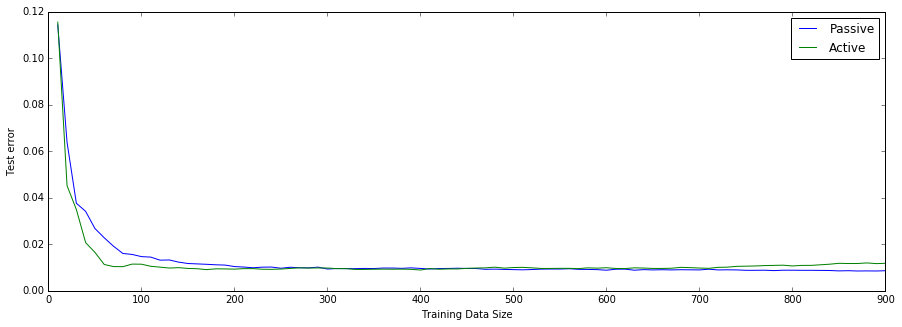

In [41]:
import matplotlib.pyplot as plt
passive_mean = []
active_mean = []
passive_array_transpose = np.array(passive_array).T
active_array_transpose = np.array(active_array).T
for i in range(90):
    mean = np.sum(passive_array_transpose[i])/50
    passive_mean.append(mean)
    mean = np.sum(active_array_transpose[i])/50
    active_mean.append(mean)
plt.figure(figsize=(15, 5))
x_axis = range(10, 901, 10)
active,=plt.plot(x_axis, passive_mean,label='Passive')
passive,=plt.plot(x_axis, active_mean,label='Active')
plt.legend(handles=[active,passive])
plt.ylabel('Test error')
plt.xlabel('Training Data Size')
plt.show()

From the graph we can conclude that Active learning achieves the minimum error faster that passive learning. Hence in cases of online algorithm active learning can be very effective.